## Tesis CCS COMPUTACIÓN UNSA
#### Ing. Vargas Mauricio

In [1]:
cd F:\Maestria\TESIS\

F:\Maestria\TESIS


In [8]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast, TFTrainer, TFTrainingArguments

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

import numpy as np
from sklearn.metrics import classification_report

import pandas as pd

import re

In [9]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [10]:
import tensorflow as tf
print(tf.sysconfig.get_build_info()['cudnn_version'])

64_8


In [11]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
df= pd.read_csv('./BD_POL/data_extended.csv')
df.head()

,Unnamed: 0,full_text,POS,clean_text,label,text_changed
0,0,"Sin ser fan de Juan Gabriel, siempre supe que ...",P,fan juan gabriel supe fuerza naturaleza escuch...,2,fan juan gabriel supe naturaleza escuche quer...
1,1,Sabes que no tendrás un buen día cuando lo pri...,N,tendras ana tratar cambiar foco cae cara,0,tendras ana tratar cambiar foco cae caradura
2,2,"En situaciones en las que no sepas que hacer, ...",N,situaciones sepas sumergete podras escuchar al...,0,situaciones situaciones sepas sumergete podra...
3,3,ayer preguntaban y dónde están las solteras!!!...,NEU,preguntaban solteras grupo alza mano unica vol...,1,preguntaban solteras grupo alza alza alza man...
4,4,Que el finde sea para hacer cualquier cosa que...,NEU,finde cosa haga feliz reverenda gana,1,finde elemento haga feliz reverenda gana


In [13]:
df_w = df[["label", "text_changed"]]

In [14]:
df_w['text_changed'] = df_w['text_changed'].str.lower()
df_w["text_changed"] = df_w["text_changed"].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()
df_w['text_changed'] = df_w['text_changed'].str.replace(
    r'[^a-z0-9\s]',
    '',
    regex=True,
    flags=re.IGNORECASE
)
df_w = df_w.dropna()

C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C

In [15]:
df_w.shape

(36117, 2)

In [16]:
df_w = df_w.sample(frac=1, random_state = 1) 
# df_w = df_w[:20000]

In [17]:
df_train = df_w[:22000]
df_val = df_w[22000:30000]
df_test = df_w[30000:]

In [18]:
df_test.shape

(6117, 2)

### Crear Tokens y Tensorizar

In [43]:
from transformers import DistilBertTokenizerFast
import tensorflow as tf

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-multilingual-cased")

def tokenize_dataframe(df):
    tokens = tokenizer(
        list(df["text_changed"]),
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="np"
    )
    return tokens, df["label"].astype("int32").values
    
def build_dataset(tokens, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(({
        "input_ids": tf.convert_to_tensor(tokens["input_ids"]),
        "attention_mask": tf.convert_to_tensor(tokens["attention_mask"])
    }, tf.convert_to_tensor(labels)))
    
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size)

In [45]:
from transformers import TFDistilBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=3)

optimizer = Adam(learning_rate=5e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    # primero tokeniza
X_train, y_train = tokenize_dataframe(df_train)
X_val, y_val = tokenize_dataframe(df_val)
    # segundo tensoriza
train_dataset = build_dataset(X_train, y_train)
val_dataset = build_dataset(X_val, y_val, shuffle=False)

model.fit(train_dataset, validation_data=val_dataset, epochs=20, batch_size=16)


Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['dropout_79', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream ta

Epoch 1/20
688/688 [==============================] - 103s 146ms/step - loss: 0.5759 - accuracy: 0.7614 - val_loss: 0.2910 - val_accuracy: 0.8985
Epoch 2/20
688/688 [==============================] - 100s 145ms/step - loss: 0.1719 - accuracy: 0.9390 - val_loss: 0.1588 - val_accuracy: 0.9484
Epoch 3/20
688/688 [==============================] - 100s 145ms/step - loss: 0.0919 - accuracy: 0.9662 - val_loss: 0.1295 - val_accuracy: 0.9578
Epoch 4/20
688/688 [==============================] - 100s 145ms/step - loss: 0.0649 - accuracy: 0.9755 - val_loss: 0.1305 - val_accuracy: 0.9607
Epoch 5/20
688/688 [==============================] - 100s 146ms/step - loss: 0.0525 - accuracy: 0.9813 - val_loss: 0.1246 - val_accuracy: 0.9619
Epoch 6/20
688/688 [==============================] - 100s 146ms/step - loss: 0.0518 - accuracy: 0.9801 - val_loss: 0.1533 - val_accuracy: 0.9567
Epoch 7/20
688/688 [==============================] - 100s 145ms/step - loss: 0.0391 - accuracy: 0.9845 - val_loss: 0.1388 -

In [46]:
# Guardar el modelo
model.save_pretrained("modelo_finetune")
tokenizer.save_pretrained("modelo_finetune")

('modelo_finetune\\tokenizer_config.json',
 'modelo_finetune\\special_tokens_map.json',
 'modelo_finetune\\vocab.txt',
 'modelo_finetune\\added_tokens.json',
 'modelo_finetune\\tokenizer.json')

## Test del modelo

In [5]:
## Asegurese de estar en el lugar donde se guardó el modelo entrenado
cd F:\Maestria\TESIS\

F:\Maestria\TESIS


In [6]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast

model = TFDistilBertForSequenceClassification.from_pretrained("modelo_finetune")
tokenizer = DistilBertTokenizerFast.from_pretrained("modelo_finetune")

Some layers from the model checkpoint at modelo_finetune were not used when initializing TFDistilBertForSequenceClassification: ['dropout_79']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at modelo_finetune and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report

tokens = tokenizer(
    list(df_test["text_changed"]),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="np"
)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": tf.convert_to_tensor(tokens["input_ids"]),
        "attention_mask": tf.convert_to_tensor(tokens["attention_mask"])
    },
    tf.convert_to_tensor(df_test["label"].values)
)).batch(48)

# Predicción
y_logits = model.predict(test_dataset).logits
y_pred = np.argmax(y_logits, axis=1)

# Evaluación
print(classification_report(df_test["label"].values, y_pred))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2792
           1       0.96      0.94      0.95      1533
           2       0.98      0.96      0.97      1792

    accuracy                           0

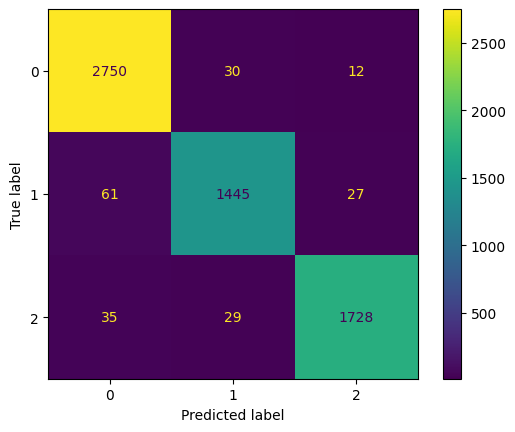

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy

confusion_matrix = confusion_matrix(df_test["label"].values, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()